In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats

from src.utilities import build_mesh
from src.covariance_function import Gaussian as GaussianCovariance
from src.covariance_function import JCSS, Matern
from src.random_field import MatrixDecomposition as MD
from src.probability_distribution import Gaussian, LogNormal, Weibull

### Papers

[Advances in Gaussian random field generation: a review](https://link.springer.com/content/pdf/10.1007/s10596-019-09867-y.pdf)

[Computational modeling of size effects in concrete specimens under uniaxial tension](https://link.springer.com/article/10.1007/s10704-009-9316-9) 

### Build mesh - material points

In [2]:
x = build_mesh(5e-3, 50, 50)

Number of nodes: 2500


### Material properties

In [3]:
lc = 15          # Length scale
mean_fc = 42.3   # Mean compressive strength
std_dev = 5      # Standard deviation compressive strength

### Build correlation matrix

In [4]:
# jcss = JCSS(lc, 0.0)
# C = jcss.build_correlation_matrix(x)
# jcss.visualise(C)

In [5]:
# gc = GaussianCovariance(lc, sigma=1)
# C = gc.build_correlation_matrix(x)
# gc.visualise(C)

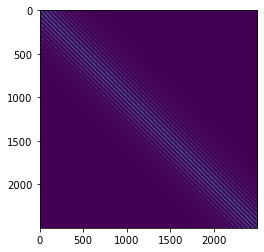

In [6]:
matern = Matern(lc, nu=1/2)
C = matern.build_correlation_matrix(x)
matern.visualise(C)

### Build Gaussian distribution

Mean : 42.49
Standard deviation : 2.97
Coefficient of variation (%) : 6.99


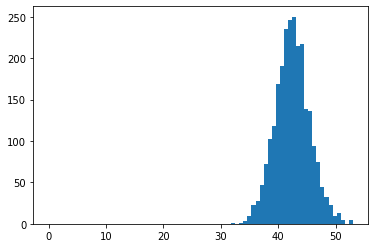

In [7]:
gaussian = Gaussian(mean_fc, std_dev)
md = MD(C, gaussian)
K = md.generate_sample()
plt.hist(K, 75, range=(0, np.max(K)));
gaussian.print_distribution_properties(K)

Mean : 42.53
Standard deviation : 2.88
Coefficient of variation (%) : 6.77


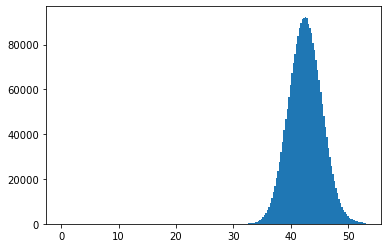

In [8]:
K_array = md.generate_samples(1000)
plt.hist(K_array.flatten(), 200, range=(0, np.max(K)));
gaussian.print_distribution_properties(K_array)

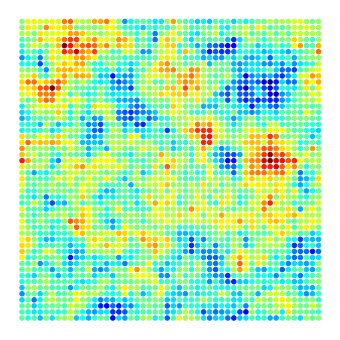

In [9]:
md.visualise(x, K, sz=20);

### Build log-normal distribution

Examine the Nataf transformation. The correlation matrix must be modified.

[Nataf transformation based point estimate method](https://link.springer.com/content/pdf/10.1007/s11434-008-0351-0.pdf)

In [10]:
def nataf_transformation(C, std_dev):
    return (np.exp(std_dev**2 * C) - 1) / (np.exp(std_dev) - 1)

Mean : 36.81
Standard deviation : 14.93
Coefficient of variation (%) : 40.56


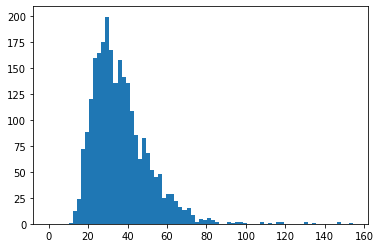

In [11]:
lognormal = LogNormal(mean_fc, 800)
md = MD(C, lognormal)
K = md.generate_sample()
plt.hist(K, 75, range=(0, np.max(K)));
lognormal.print_distribution_properties(K)

Mean : 38.46
Standard deviation : 14.20
Coefficient of variation (%) : 36.92


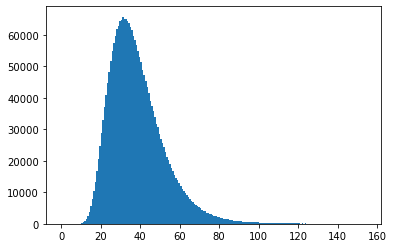

In [12]:
K_array = md.generate_samples(1000)
plt.hist(K_array.flatten(), 200, range=(0, np.max(K)));
lognormal.print_distribution_properties(K_array)

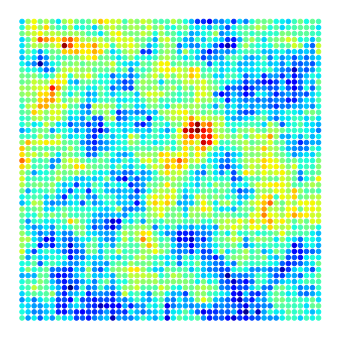

In [13]:
md.visualise(x, np.log(K), 20)

### Build Weibull distribution

Mean : 39.67
Standard deviation : 5.16
Coefficient of variation (%) : 13.01


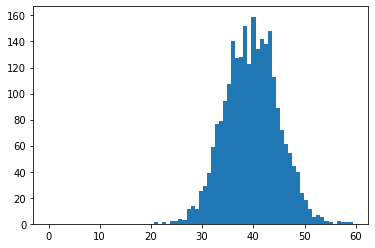

In [22]:
weibull = Weibull(mean_fc, std_dev, 5)
md = MD(C, weibull)
K = md.generate_sample()
plt.hist(K, 75, range=(0, np.max(K)));
weibull.print_distribution_properties(K)

Mean : 39.54
Standard deviation : 5.16
Coefficient of variation (%) : 13.04


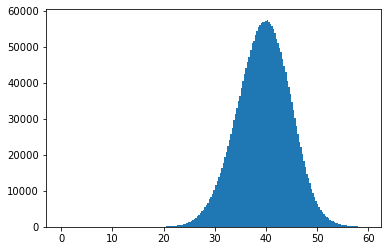

In [23]:
K_array = md.generate_samples(1000)
plt.hist(K_array.flatten(), 200, range=(0, np.max(K)));
weibull.print_distribution_properties(K_array)

### Build Weibull distribution - original

In [16]:
gaussian = Gaussian(mean_fc, std_dev)
md = MD(C, gaussian)
K = md.generate_sample() # sample of the random field

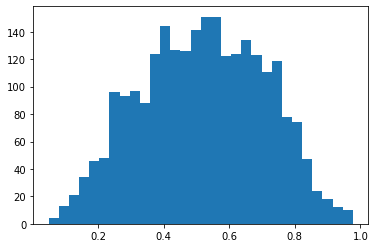

In [17]:
rv_norm = stats.norm.cdf(K, mean_fc, std_dev)
plt.hist(rv_norm, 30);

In the field of materials science, the shape parameter $k$ of a distribution of strengths is known as the Weibull modulus. The Weibull modulus is a dimensionless parameter of the Weibull distribution which is used to describe variability in measured material strength of brittle materials.

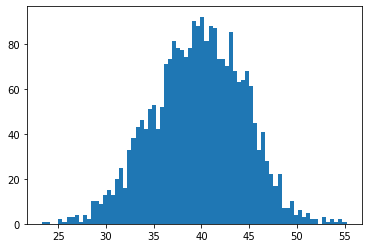

In [18]:
shape = 5
rv_weib = stats.weibull_min.ppf(rv_norm, shape, loc=0, scale=42.3)
plt.hist(rv_weib, 75);

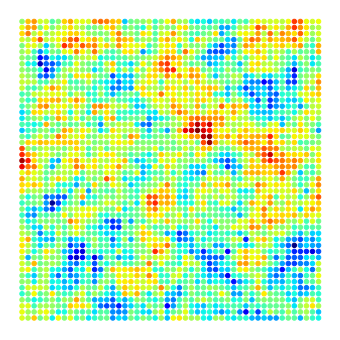

In [19]:
md.visualise(x, rv_weib, sz=20);